In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data collection

In [2]:
df = pd.read_csv("diamonds.csv")
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### Data preprocessing

In [3]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [4]:
print('before',df.duplicated().sum())
df=df.drop_duplicates()
print('after',df.duplicated().sum())

before 146
after 0


In [5]:
(df[['x','y','z']]==0).sum()

x     7
y     6
z    19
dtype: int64

In [6]:
df[['x','y','z']]=df[['x','y','z']].replace(0,np.nan)

#
df['x']=df['x'].fillna(df['x'].median())
df['y']=df['y'].fillna(df['y'].median())
df['z']=df['z'].fillna(df['z'].median())

C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\313397798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x','y','z']]=df[['x','y','z']].replace(0,np.nan)
C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\313397798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x']=df['x'].fillna(df['x'].median())
C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\313397798.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Feature Engineering

In [7]:
 # Volume = x * y * z
df['volume'] = round(df['x'] * df['y'] * df['z'],2)

# Price per Carat
df['price_per_carat'] = round(df['price'] / df['carat'],2)

# Dimension Ratio = (x + y) / (2 * z)
df['dimension_ratio'] = round((df['x'] + df['y']) / (2 * df['z']),2)

# Carat Category (Light / Medium / Heavy)
conditions=[
(df['carat']<=0.5),
(df['carat']<=1.5),
(df['carat']>1.5)
]
choice=['light','medium','heavy']
df['carat_category']=np.select(conditions,choice, default='unknown')

# Show updated columns
df.head()

C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\2869416795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volume'] = round(df['x'] * df['y'] * df['z'],2)
C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\2869416795.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_carat'] = round(df['price'] / df['carat'],2)
C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\2869416795.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,price_per_carat,dimension_ratio,carat_category
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.20,1417.39,1.63,light
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.51,1552.38,1.67,light
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.08,1421.74,1.76,light
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.72,1151.72,1.60,light
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.92,1080.65,1.58,light


In [8]:
# Convert Price (USD → INR)
usd_to_inr = 88.64              # You can update with dynamic rate if needed
df['price_in_INR'] = df['price'] * usd_to_inr

C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\4062436895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_in_INR'] = df['price'] * usd_to_inr


In [9]:
df['carat_category'].value_counts()

carat_category
medium    29513
light     18863
heavy      5418
Name: count, dtype: int64

### Outliers

In [10]:
numeric_col = ['carat','depth','table','price','x','y','z','volume','price_per_carat','dimension_ratio','price_in_INR']

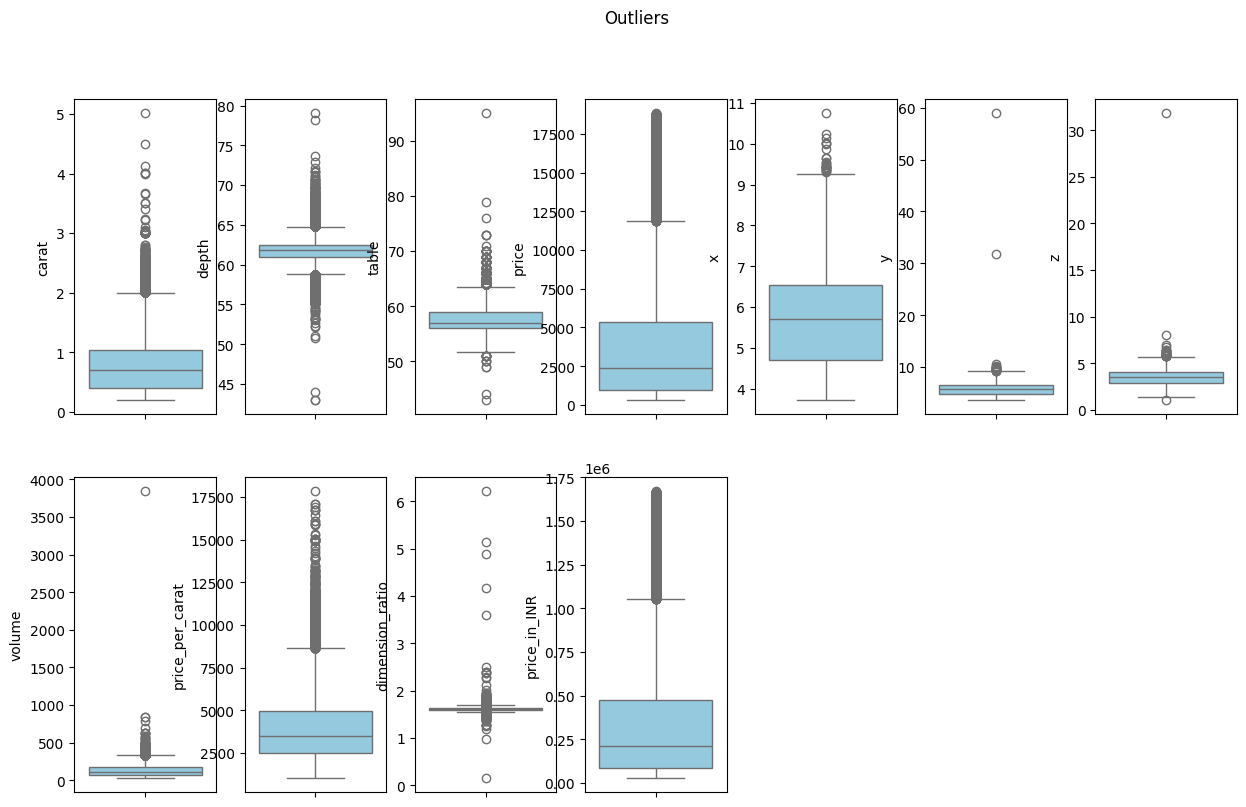

In [11]:
plt.figure(figsize=(15,9))
plt.suptitle("Outliers")
for i in range(0,len(numeric_col)):
  plt.subplot(2,7,i+1)
  sns.boxplot(y=df[numeric_col[i]],color='skyblue')

In [12]:
for col in numeric_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col]= np.where(df[col]<lower, lower, df[col])
    df[col]= np.where(df[col]>upper, upper, df[col])

C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\3794630535.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]= np.where(df[col]<lower, lower, df[col])
C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\3794630535.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]= np.where(df[col]>upper, upper, df[col])
C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\3794630535.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

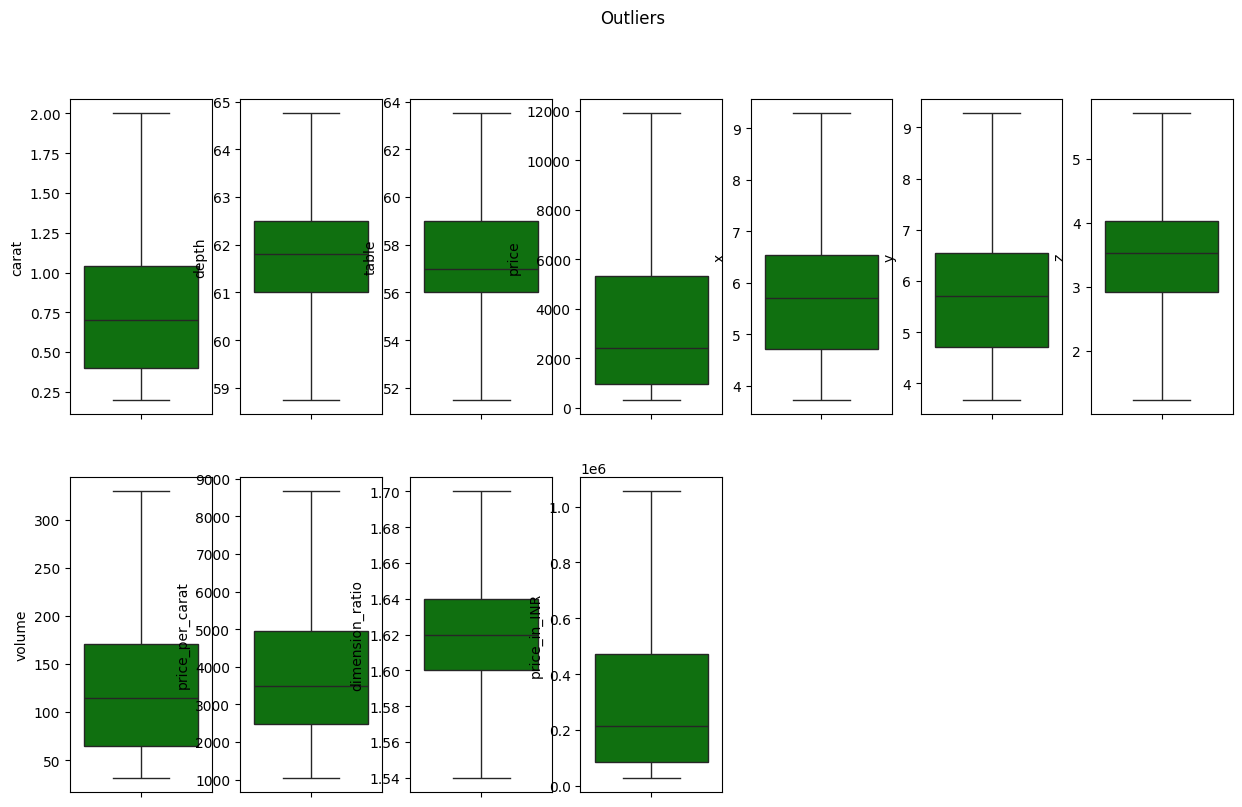

In [13]:
plt.figure(figsize=(15,9))
plt.suptitle("Outliers")
for i in range(0,len(numeric_col)):
  plt.subplot(2,7,i+1)
  sns.boxplot(y=df[numeric_col[i]],color='green')

In [14]:
skews=df[numeric_col].skew()
print(df[numeric_col].skew())

carat              0.899170
depth             -0.228563
table              0.472532
price              1.148606
x                  0.392713
y                  0.388437
z                  0.384730
volume             0.916243
price_per_carat    0.899874
dimension_ratio    0.295881
price_in_INR       1.148606
dtype: float64


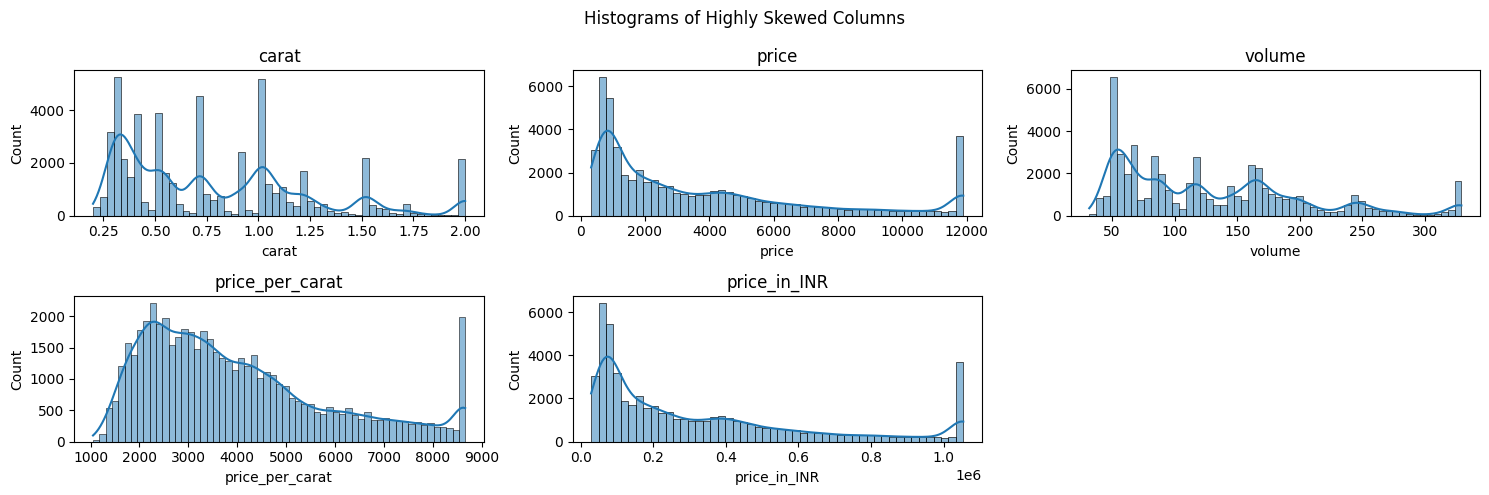

In [15]:
high_skew_cols = skews[abs(skews) > 0.5].index.tolist()

plt.figure(figsize=(15, 5))
plt.suptitle("Histograms of Highly Skewed Columns")
for i, col in enumerate(high_skew_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [16]:
print(df['price_in_INR'].min())
print(df['price_in_INR'].max())
print(df['price_in_INR'].mean())

28896.64
1053962.8399999999
330888.99254861136


In [17]:
df['price_in_INR']=np.log1p(df['price_in_INR'])

C:\Users\AKILESH\AppData\Local\Temp\ipykernel_17136\2900424723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_in_INR']=np.log1p(df['price_in_INR'])


In [18]:
print(df['price_in_INR'].min())
print(df['price_in_INR'].max())
print(df['price_in_INR'].mean())

10.271515209866436
13.868068700094552
12.25732352472448


In [19]:
df.isnull().sum()

carat              0
cut                0
color              0
clarity            0
depth              0
table              0
price              0
x                  0
y                  0
z                  0
volume             0
price_per_carat    0
dimension_ratio    0
carat_category     0
price_in_INR       0
dtype: int64

### EDA

Text(0.5, 1.0, 'Heatmap for Numerical Columns')

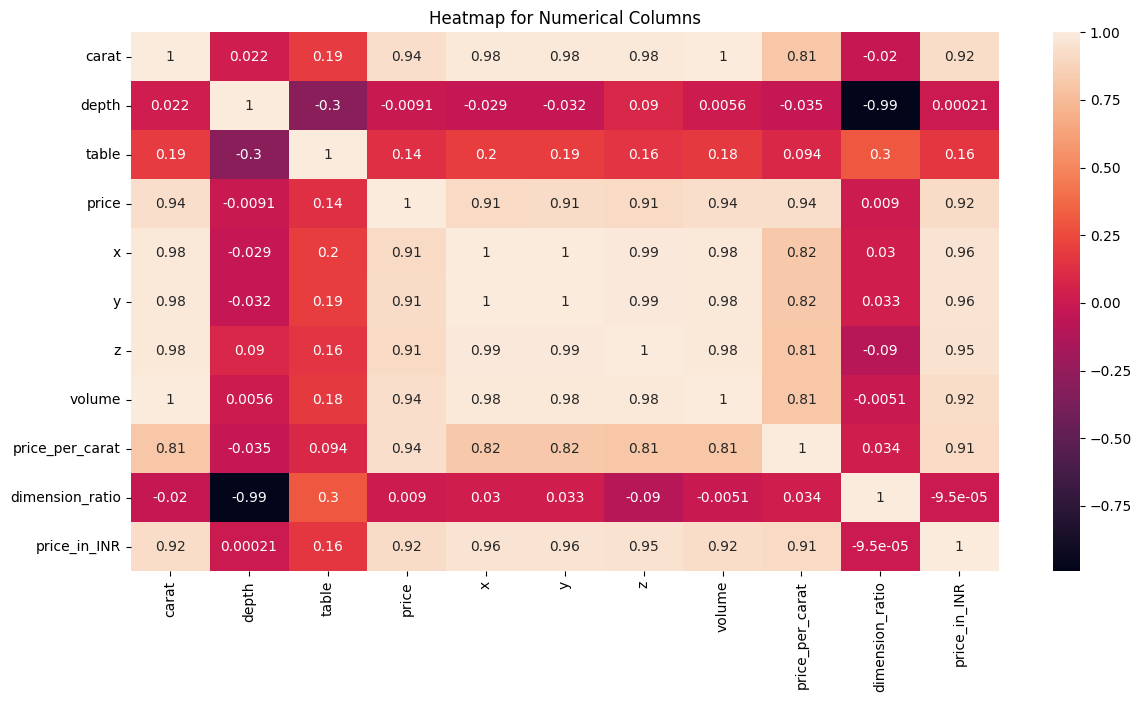

In [20]:
plt.figure(figsize=(14,7))
sns.heatmap(df[numeric_col].corr(),annot=True)
plt.title("Heatmap for Numerical Columns")

Text(0, 0.5, 'Price')

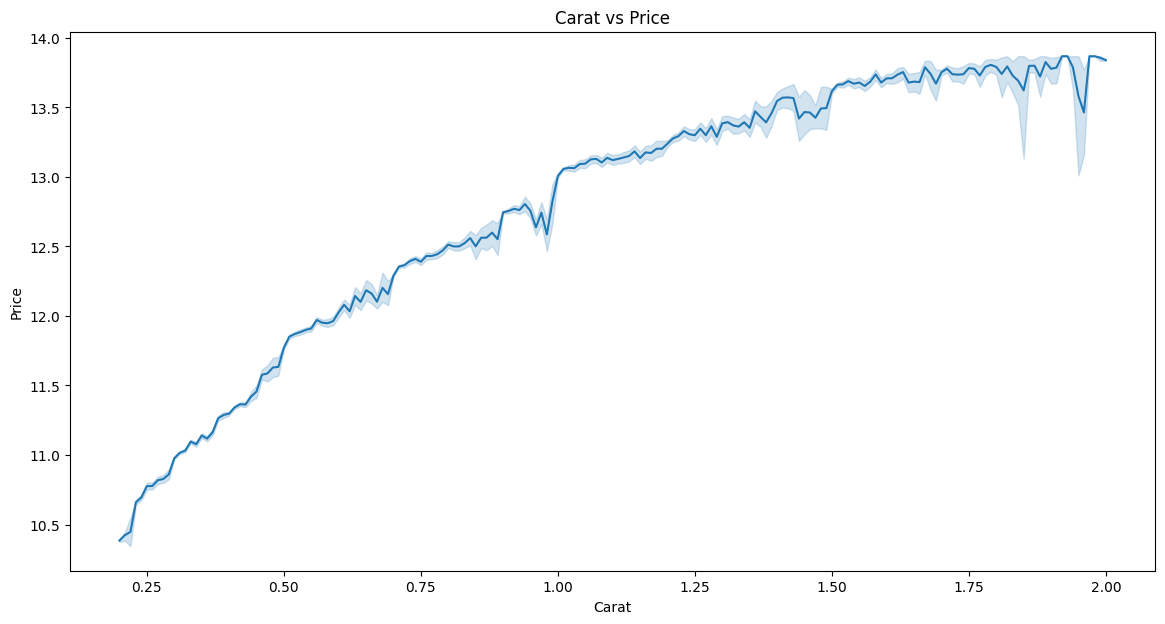

In [21]:
plt.figure(figsize=(14,7))
sns.lineplot(data=df,x=df['carat'],y=df['price_in_INR'])
plt.title("Carat vs Price")
plt.xlabel("Carat")
plt.ylabel("Price")

<Figure size 1400x700 with 0 Axes>

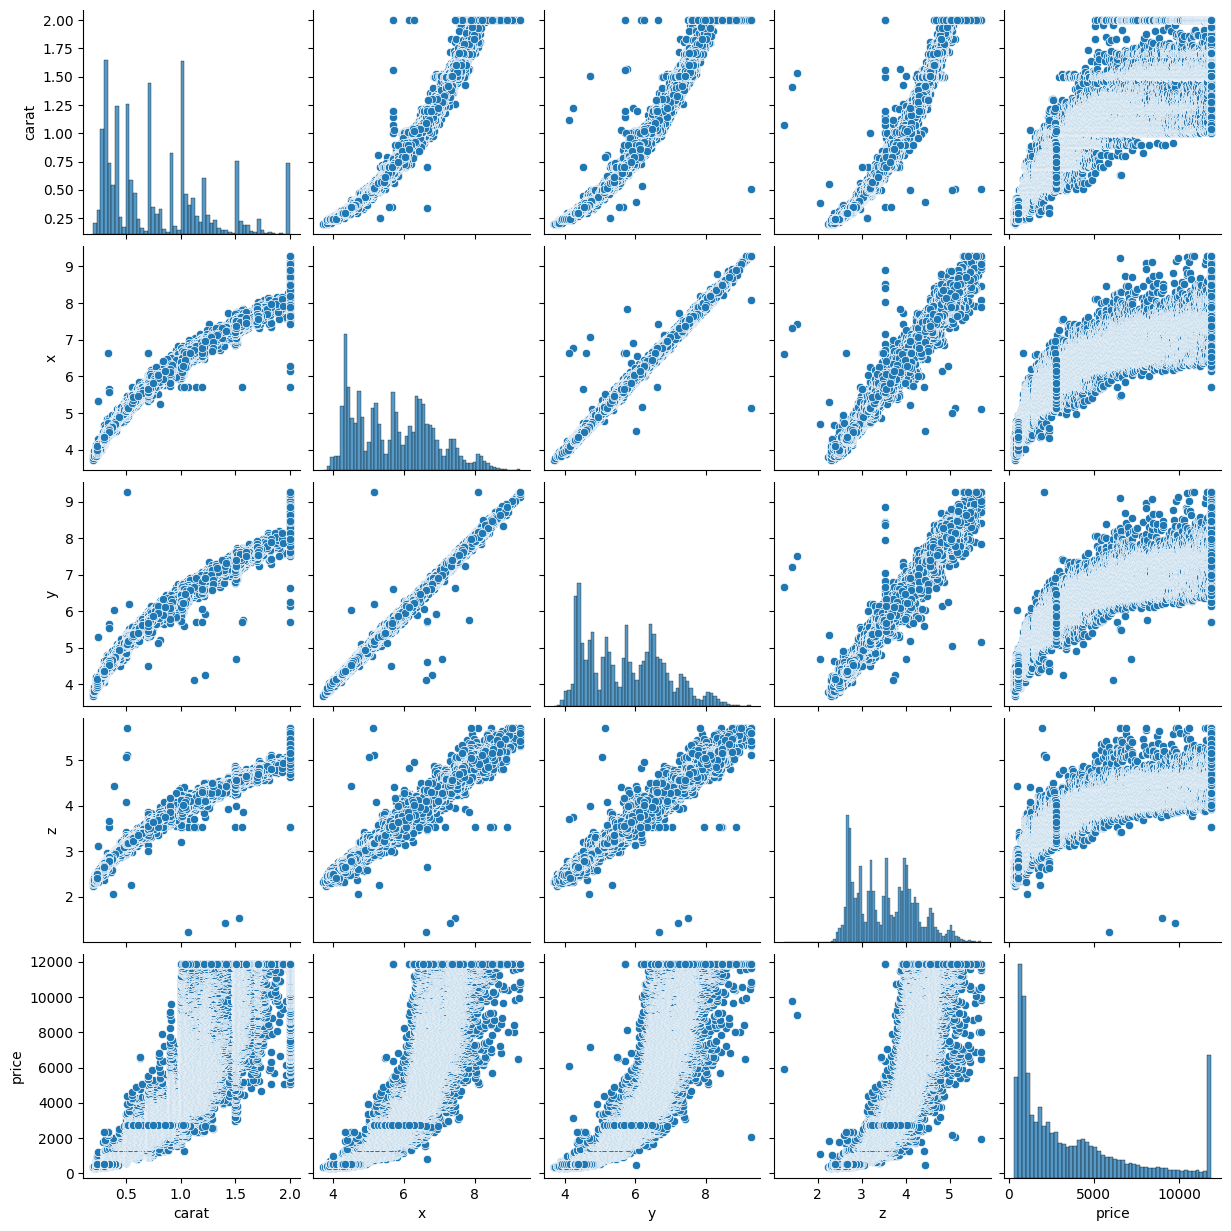

In [22]:
plt.figure(figsize=(14,7))
sns.pairplot(df[['carat','x','y','z','price']])

# Split

In [23]:
X=df.drop(['price','price_in_INR'],axis=1)
y=df['price_in_INR']

In [24]:
x_train, x_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

# Column transform

In [25]:
numeric_col= ['depth', 'table', 'x', 'y', 'z',	'dimension_ratio']
cat_cols= ['cut', 'color', 'clarity', 'carat_category']
skew_cols= ['carat','volume','price_per_carat']

cut_order= ['Fair','Good','Very Good','Premium','Ideal']
color_order= ['J','I','H','G','F','E','D']
clarity_order= ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
carat_cat_order= ['light','medium','heavy']
preprocessor= ColumnTransformer(
    transformers=[
        ('skew',Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1)),
            ('scale',StandardScaler())
        ]),skew_cols),
        ('num', StandardScaler(),numeric_col),
        ('cat',OrdinalEncoder(categories=[cut_order, color_order, clarity_order, carat_cat_order]),cat_cols)
    ]
)

# Model Building

In [26]:
models={
    'lr': LinearRegression(),
    'dt': DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'knn': KNeighborsRegressor(),
    'xgb': XGBRegressor()
    }
for name, model in models.items():
  pipeline= Pipeline([
      ('preprocessor', preprocessor),
      ('model',model)
  ])
  pipeline.fit(x_train,y_train)

  y_pred=pipeline.predict(x_test)

  mae=mean_absolute_error(y_test,y_pred)
  mse=mean_squared_error(y_test,y_pred)
  rmse=np.sqrt(mse)
  r2=r2_score(y_test,y_pred)

  print(name,'Results')
  print('score: ', pipeline.score(x_test,y_test))
  print('MAE score: ', mae)
  print('MSE score: ', mse)
  print('RMSE score: ', rmse)
  print('r2 score: ', r2)
  print("")

lr Results
score:  0.997461682259906
MAE score:  0.023297905984575273
MSE score:  0.0024252149970758648
RMSE score:  0.049246471925162974
r2 score:  0.997461682259906

dt Results
score:  0.9996324575093811
MAE score:  0.005437622453504828
MSE score:  0.0003511654771315509
RMSE score:  0.018739409732741075
r2 score:  0.9996324575093811

rf Results
score:  0.9997906317739591
MAE score:  0.0035640520580944297
MSE score:  0.00020003916518607535
RMSE score:  0.014143520254380638
r2 score:  0.9997906317739591

knn Results
score:  0.9910424855188804
MAE score:  0.06588912061524195
MSE score:  0.00855838420580491
RMSE score:  0.09251153552830539
r2 score:  0.9910424855188804

xgb Results
score:  0.9997883770354824
MAE score:  0.008492512819758914
MSE score:  0.00020219343668725475
RMSE score:  0.014219473854093714
r2 score:  0.9997883770354824



# Best Model

In [27]:
pipeline= Pipeline([
    ('preprocessor', preprocessor),
    ('model',RandomForestRegressor())
])
pipeline.fit(x_train,y_train)

with open('pipline.pkl','wb')as f:
  pickle.dump(pipeline,f)

# ANN

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
x_train_res=preprocessor.fit_transform(x_train)
x_test_res=preprocessor.transform(x_test)

y_scaler=StandardScaler()
y_train_scal=y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scal=y_scaler.transform(y_test.values.reshape(-1,1))

X_train=torch.tensor(x_train_res, dtype=torch.float32)
X_test=torch.tensor(x_test_res, dtype=torch.float32)
y_train=torch.tensor(y_train_scal, dtype=torch.float32)
y_test=torch.tensor(y_test_scal, dtype=torch.float32)

X_feature_count=X_train.shape[1]

class price_prediction(nn.Module):
  def __init__(self,input_dim):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(input_dim,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )

  def forward(self,x):
    return self.net(x)

In [32]:
model=price_prediction(X_feature_count)
loss_function=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

# ANN training

In [33]:
epochs=50
for epoch in range(epochs):
  optimizer.zero_grad()
  y_pred=model(X_train)
  loss=loss_function(y_pred,y_train)
  loss.backward()
  optimizer.step()
  print(f'epoch: {epoch+1}/{epochs}, loss: {loss.item()}')

epoch: 1/50, loss: 0.9030760526657104
epoch: 2/50, loss: 0.8282137513160706
epoch: 3/50, loss: 0.756535530090332
epoch: 4/50, loss: 0.6877813935279846
epoch: 5/50, loss: 0.6217640042304993
epoch: 6/50, loss: 0.5584275722503662
epoch: 7/50, loss: 0.49777698516845703
epoch: 8/50, loss: 0.4400161802768707
epoch: 9/50, loss: 0.38536974787712097
epoch: 10/50, loss: 0.3340817987918854
epoch: 11/50, loss: 0.2863861620426178
epoch: 12/50, loss: 0.2425914704799652
epoch: 13/50, loss: 0.20298506319522858
epoch: 14/50, loss: 0.16777127981185913
epoch: 15/50, loss: 0.13709694147109985
epoch: 16/50, loss: 0.1110449805855751
epoch: 17/50, loss: 0.08960815519094467
epoch: 18/50, loss: 0.07270904630422592
epoch: 19/50, loss: 0.060150906443595886
epoch: 20/50, loss: 0.05161207541823387
epoch: 21/50, loss: 0.04660702496767044
epoch: 22/50, loss: 0.044471826404333115
epoch: 23/50, loss: 0.04438869282603264
epoch: 24/50, loss: 0.045432548969984055
epoch: 25/50, loss: 0.04672038182616234
epoch: 26/50, loss

# ANN Testing

In [34]:
model.eval()

with torch.no_grad():
  y_pred_test=model(X_test)
  test_loss=loss_function(y_pred_test,y_test)
  print(f'test loss: {test_loss.item()}')

  mae=mean_absolute_error(y_test,y_pred_test)
  mse=mean_squared_error(y_test,y_pred_test)
  rmse=np.sqrt(mse)
  r2=r2_score(y_test,y_pred_test)

  print('MAE score: ', mae)
  print('MSE score: ', mse)
  print('RMSE score: ', rmse)
  print('r2 score: ', r2)

test loss: 0.008596891537308693
MAE score:  0.07097566872835159
MSE score:  0.008596892468631268
RMSE score:  0.09271942875488
r2 score:  0.9911432862281799


# Clustering

In [35]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Kmeans

In [36]:
k_val=range(2,11)
inertias=[]
for k in k_val:
  kmeans=KMeans(n_clusters=k,random_state=42)
  kmeans_labels=kmeans.fit_predict(x_train_res)
  km_sil_score=(silhouette_score(x_train_res,kmeans_labels))
  print(k,"Cluster-> Silhouette Score:",km_sil_score,"inertia:",kmeans.inertia_)
  inertias.append(kmeans.inertia_)

2 Cluster-> Silhouette Score: 0.27441983035421924 inertia: 481687.66168980947
3 Cluster-> Silhouette Score: 0.20290826337610907 inertia: 425958.49987026124
4 Cluster-> Silhouette Score: 0.17170987176551247 inertia: 383723.4603541039
5 Cluster-> Silhouette Score: 0.1752456500617546 inertia: 353390.2162208479
6 Cluster-> Silhouette Score: 0.17596294339740645 inertia: 330775.1253444657
7 Cluster-> Silhouette Score: 0.1794082759269493 inertia: 310762.39855829347
8 Cluster-> Silhouette Score: 0.18148717121017746 inertia: 286079.7168816379
9 Cluster-> Silhouette Score: 0.1785334168250736 inertia: 271488.55720982264
10 Cluster-> Silhouette Score: 0.17046374420094873 inertia: 261853.03665068757


# DBScan

In [39]:
eps=[1.0,1.5,2.0,2.5]
for epss in eps:
  dbscan=DBSCAN(eps=epss,min_samples=30)
  dbscan_labels=dbscan.fit_predict(x_train_res)
  db_sil_score=silhouette_score(x_train_res,dbscan_labels)
  print('eps',epss,'-> Silhouette Score',db_sil_score)

eps 1.0 -> Silhouette Score -0.2471909291021609
eps 1.5 -> Silhouette Score 0.21105140974555464
eps 2.0 -> Silhouette Score 0.241845331677743
eps 2.5 -> Silhouette Score 0.22131255365358266


# PCA

In [40]:
pca=PCA(n_components=2)
x_pca=pca.fit_transform(x_train_res)

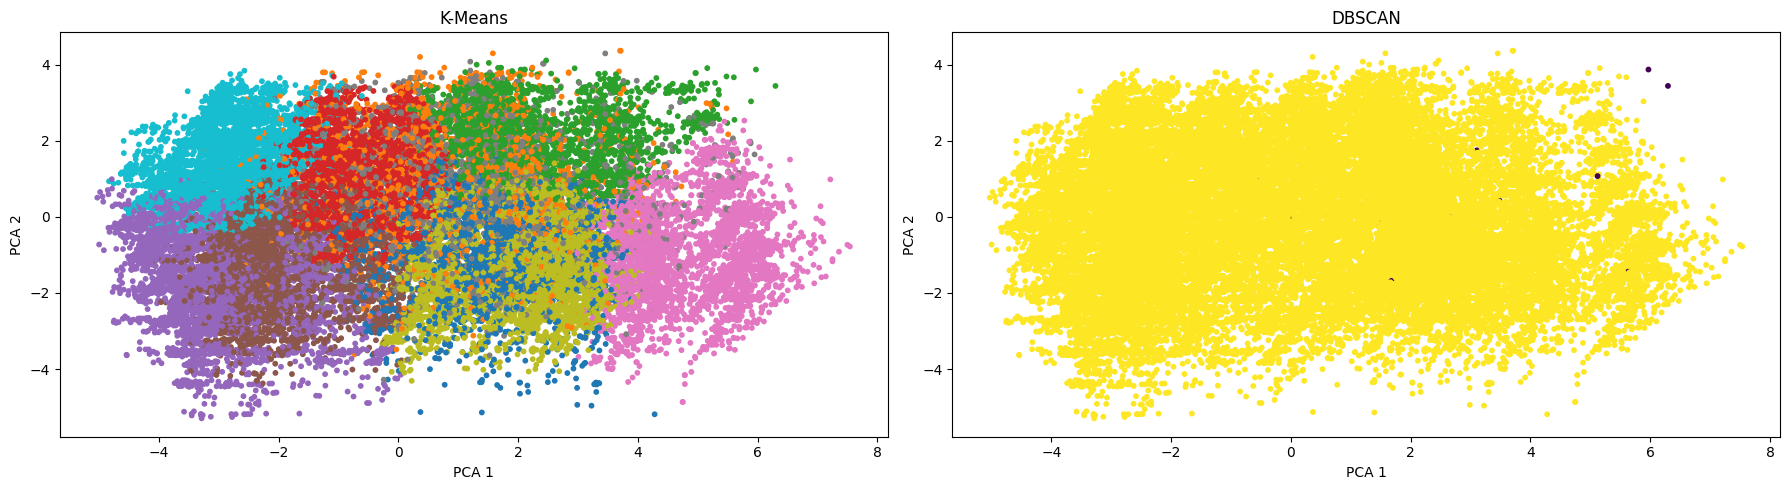

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].scatter(x_pca[:,0], x_pca[:,1], c=kmeans_labels, cmap='tab10', s=10)
axes[0].set_title('K-Means')

axes[1].scatter(x_pca[:,0], x_pca[:,1], c=dbscan_labels, cmap='viridis', s=10)
axes[1].set_title('DBSCAN')

for ax in axes:
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

# Best Model

In [42]:
  kmeans=KMeans(n_clusters=2,random_state=42)
  kmeans_labels=kmeans.fit_predict(x_train_res)
  km_sil_score=(silhouette_score(x_train_res,kmeans_labels))
  print("2 Cluster-> Silhouette Score:",km_sil_score,"inertia:",kmeans.inertia_)

2 Cluster-> Silhouette Score: 0.27441983035421924 inertia: 481687.66168980947


In [44]:
dbscan=DBSCAN(eps=2.0,min_samples=30)
dbscan_labels=dbscan.fit_predict(x_train_res)
db_sil_score=silhouette_score(x_train_res,dbscan_labels)
print('eps 2.0 -> Silhouette Score',db_sil_score)

eps 2.0 -> Silhouette Score 0.241845331677743


# Cluster EDA

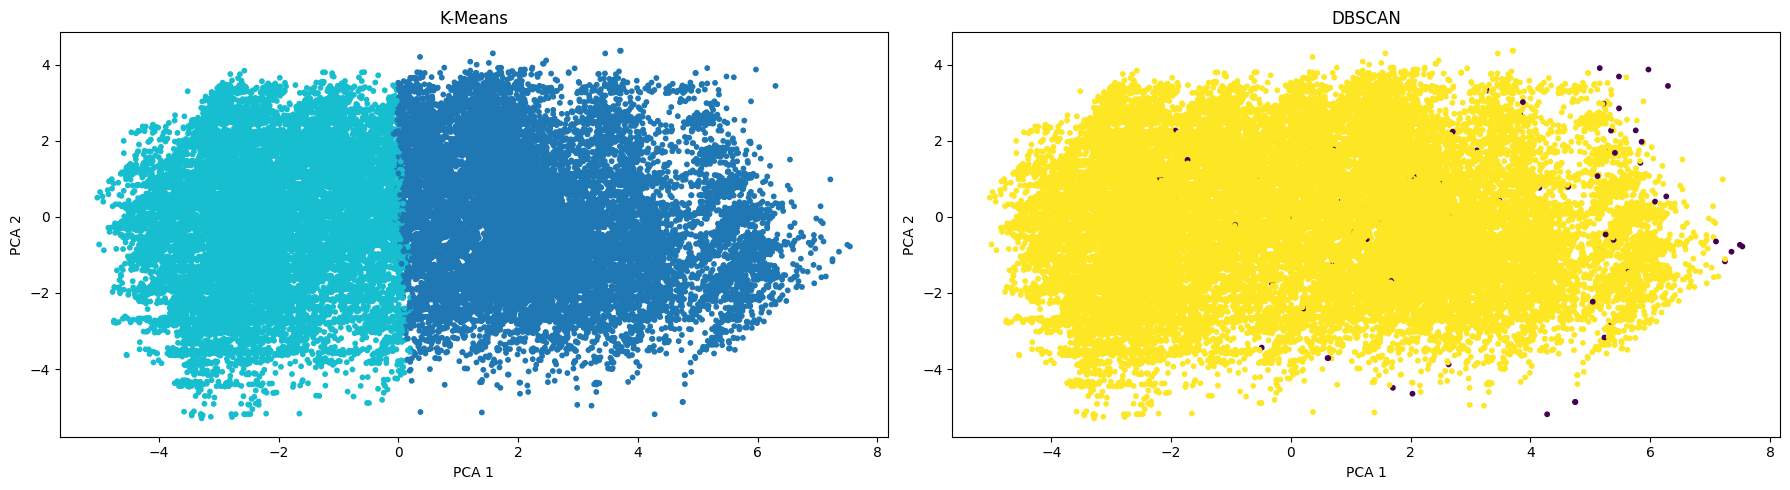

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].scatter(x_pca[:,0], x_pca[:,1], c=kmeans_labels, cmap='tab10', s=10)
axes[0].set_title('K-Means')

axes[1].scatter(x_pca[:,0], x_pca[:,1], c=dbscan_labels, cmap='viridis', s=10)
axes[1].set_title('DBSCAN')

for ax in axes:
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

In [46]:
y_train_inv=y_scaler.inverse_transform(y_train_scal)

In [47]:
df_cluster=pd.DataFrame({
    'KMeans_labels':kmeans_labels,
    'DBSCAN_labels':dbscan_labels,
    'Price_inr':y_train_inv[:,0],
    'carat':x_train_res[:,0],
    'cut':x_train_res[:,9]
})

In [48]:
df_cluster.groupby('KMeans_labels')[['Price_inr','carat']].mean()

,Price_inr,carat
KMeans_labels,,
0,13.100252,0.863096
1,11.445831,-0.830395


In [49]:
df_cluster.groupby('KMeans_labels')['cut'].value_counts()

KMeans_labels  cut
0              3.0     6349
               4.0     6149
               2.0     5176
               1.0     2385
               0.0     1043
1              4.0    10983
               3.0     4735
               2.0     4477
               1.0     1513
               0.0      225
Name: count, dtype: int64

In [50]:
with open('preprocessor.pkl','wb')as f:
  pickle.dump(preprocessor,f)

with open('KMeans.pkl','wb')as f:
  pickle.dump(kmeans,f)